Neural Linear Model Uncertainty Quantification.

Translated to JAX from https://colab.research.google.com/drive/1bOS3CcLukgjs-0-spm5GvwTBK7jgoDnc?usp=sharing#scrollTo=YwmW2StCzixH

# 0. Imports, Dataset, and MLP Model

In [1]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
from jax import vmap, jit, value_and_grad
import seaborn as sns
import optax
import ml_collections
from flax.training import train_state
from flax import linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

rc = {
    "figure.constrained_layout.use": True,
    "axes.titlesize": 20,
    "figure.figsize": (12, 9),
}
sns.set_theme(style="darkgrid", palette="colorblind", rc=rc)

In [2]:
def generate_dataset(n_train, obs_var, key=0, in_between=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    
    if in_between:
        mask = jr.bernoulli(key, p=0.5, shape=(n_train,))
        key1, key2, subkey = jr.split(subkey, 3)
        X_train = (-2 * jr.uniform(key1, (n_train,)) - 1) * mask + \
            (2 * jr.uniform(key2, (n_train,)) + 1) * (1. - mask)
    else:
        X_train = jr.normal(key, (n_train,))

    w = jnp.array([-0.6667, -0.6012, -1.0172, -0.7687, 1.4680, -0.1678])
    def f(x, key):
        fx = w @ jnp.power(x, jnp.arange(len(w)))
        fx *= jnp.sin(jnp.pi * x)
        fx *= jnp.exp(-0.5 * (x**2)) / jnp.sqrt(2 * jnp.pi)
        return fx + obs_var * jr.normal(key)
    
    keys = jr.split(subkey, n_train)
    y_train = vmap(f)(X_train, keys)

    return X_train, y_train


In [3]:
def get_adamw_config(learning_rate=0.01, weight_decay=1e-4, batch_size=1, num_epochs=1):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.learning_rate = learning_rate
    config.weight_decay = weight_decay
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    return config


Generate full dataset

In [4]:
n_train = 200
obs_var = 0.1

X_train, y_train = generate_dataset(n_train, obs_var)

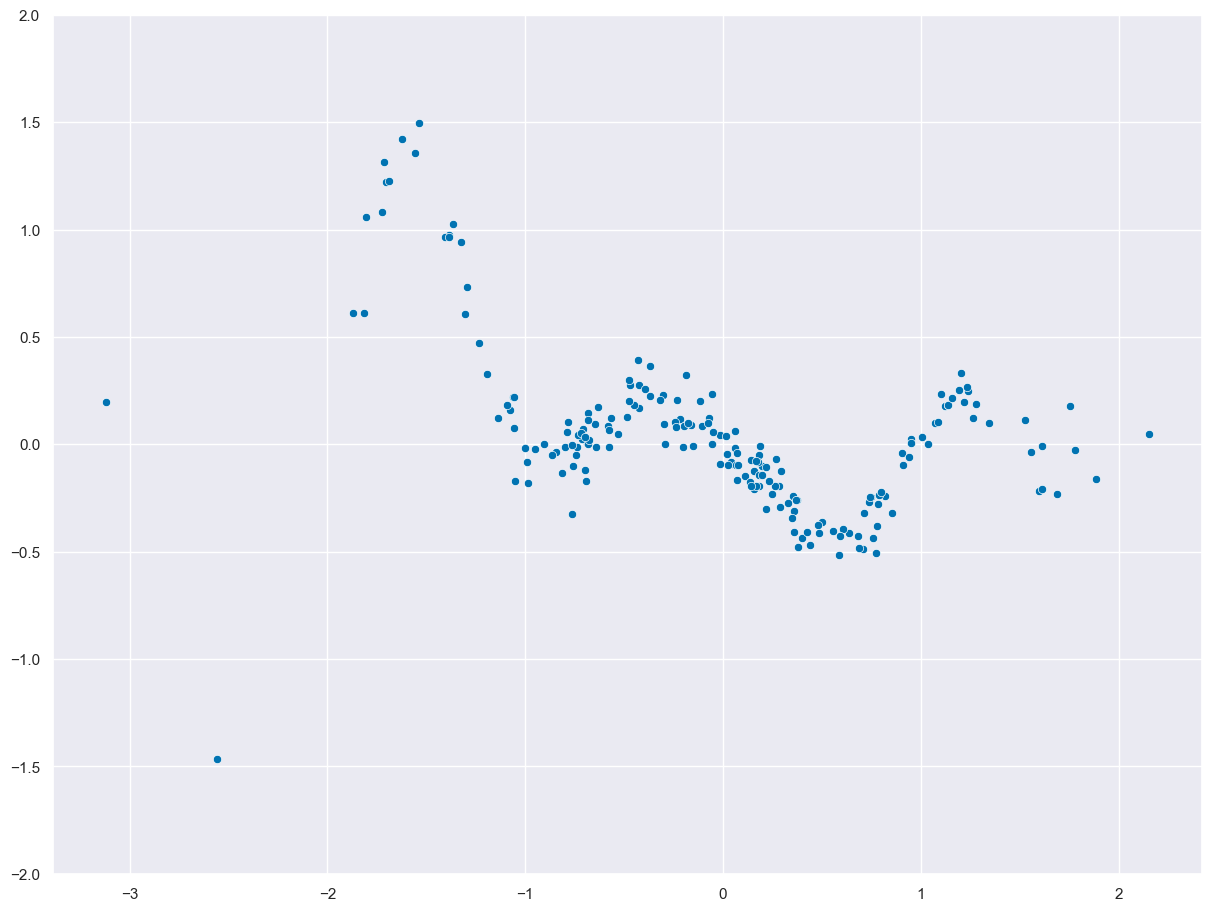

In [5]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax.set_ylim(-2., 2.);

Generate in-between dataset

In [6]:
X_inbtwn_train, y_inbtwn_train = generate_dataset(n_train, obs_var, in_between=True)

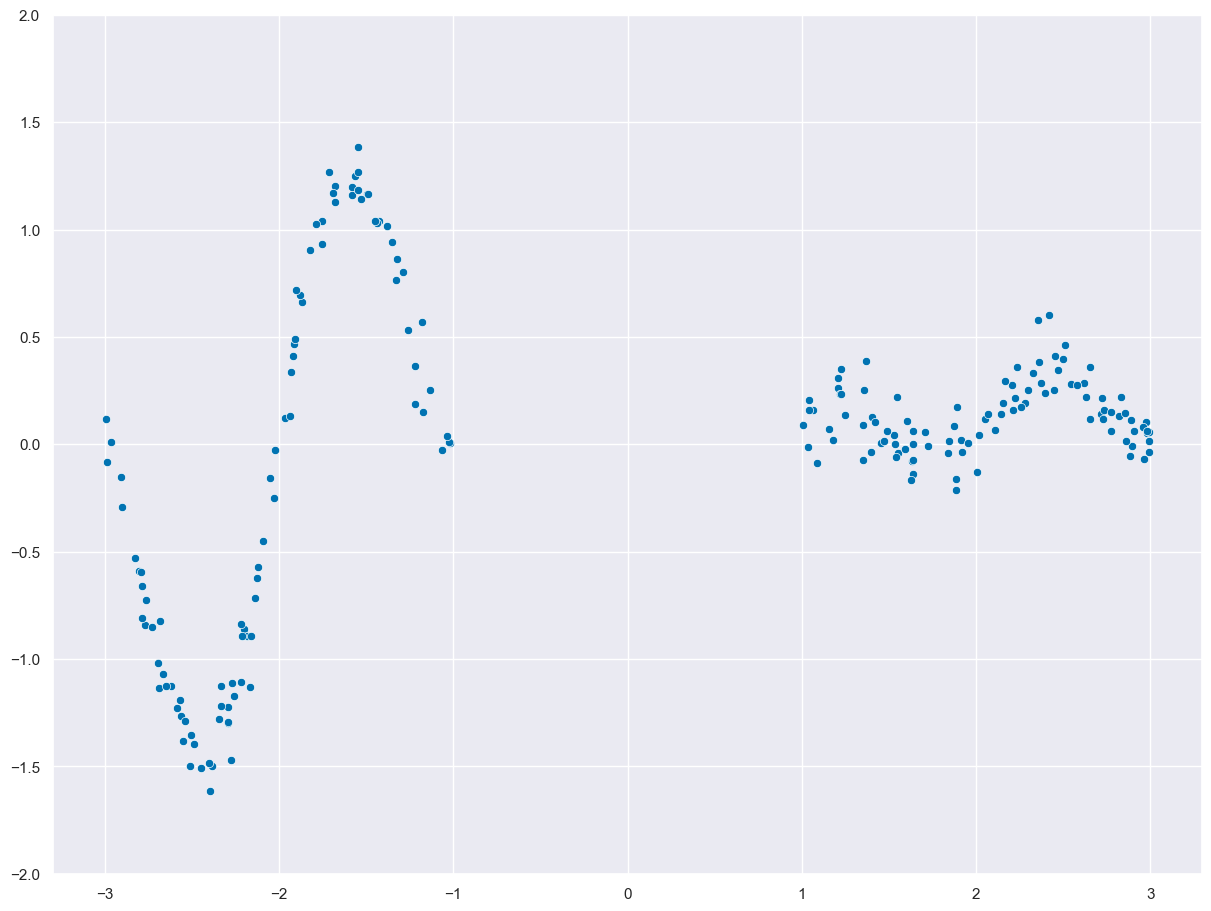

In [7]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax.set_ylim(-2., 2.);

Define an MLP model with separate features and output components to enable intermediate result extraction.

In [35]:
class MLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.penultimate = Features(self.features)
        self.output = Output()

    def __call__(self, x):
        x = self.penultimate(x)
        x = self.output(x)
        return x

class Features(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.relu(nn.Dense(feat)(x))
        return x

class Output(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dense(1)(x)

In [36]:
n_features = 100
features = [n_features] * 3
model = MLP(features=features)
params = model.init(jr.PRNGKey(0), jnp.ones((1,)))
flat_params, unflatten_fn = ravel_pytree(params)
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))
apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

# Extract penultimate layer results
get_features = lambda params, x: model.apply(
    unflatten_fn(params), jnp.atleast_1d(x), 
    method=lambda module, x: module.penultimate(jnp.atleast_1d(x))
)
print(flat_params.shape)

(20501,)


# 1. Neural Linear Model 

## 1.1 Point Estimates

### 1.1.1 Full Dataset

In [25]:
config = get_adamw_config(
    learning_rate=1e-3, weight_decay=1/(2*0.95*n_train), batch_size=32, num_epochs=500
)

In [26]:
@jit
def compute_loss_and_updates(state, X_batch, y_batch):
    def loss_fn(params):
        preds = vmap(state.apply_fn, (None, 0))(params, X_batch).squeeze()
        loss = jnp.mean(optax.l2_loss(preds, y_batch))
        return loss

    grad_fn = value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    return grads, loss

In [27]:
def fit(config, apply_fn, flat_params, n_train, X_train, y_train):
    # Initialize the optimizer
    tx = optax.adamw(learning_rate=config.learning_rate, weight_decay=config.weight_decay)
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)

    for epoch in range(1, config.num_epochs+1):
        # Keep track of the loss
        train_loss = []

        # Shuffle the data at the beginning of each epoch
        key = jr.PRNGKey(epoch)
        perm = jr.permutation(key, n_train)
        perm = perm[:(n_train//config.batch_size)*config.batch_size].reshape(
            (n_train//config.batch_size, config.batch_size)
        )

        for batch in perm:
            X_batch, y_batch = X_train[batch], y_train[batch]
            grads, loss = compute_loss_and_updates(opt_state, X_batch, y_batch)
            opt_state = opt_state.apply_gradients(grads=grads)
            train_loss.append(loss)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch} - loss: {jnp.mean(jnp.array(train_loss))}")
    
    return opt_state

In [28]:
config = get_adamw_config(
    learning_rate=1e-3, weight_decay=1/(2*0.95*n_train), batch_size=32, num_epochs=500
)

In [29]:
trained_state = fit(config, apply_fn, flat_params, n_train, X_train, y_train)

Epoch 20 - loss: 0.04770651459693909
Epoch 40 - loss: 0.031542327255010605
Epoch 60 - loss: 0.042801134288311005
Epoch 80 - loss: 0.04094097763299942
Epoch 100 - loss: 0.03966302424669266
Epoch 120 - loss: 0.0356447733938694
Epoch 140 - loss: 0.03425154089927673
Epoch 160 - loss: 0.02869994193315506
Epoch 180 - loss: 0.018963228911161423
Epoch 200 - loss: 0.015769220888614655
Epoch 220 - loss: 0.014149673283100128
Epoch 240 - loss: 0.011278977617621422
Epoch 260 - loss: 0.011513344012200832
Epoch 280 - loss: 0.01267001312226057
Epoch 300 - loss: 0.010311569087207317
Epoch 320 - loss: 0.010929090902209282
Epoch 340 - loss: 0.010568888857960701
Epoch 360 - loss: 0.009252088144421577
Epoch 380 - loss: 0.008617674931883812
Epoch 400 - loss: 0.008183051832020283
Epoch 420 - loss: 0.007244465872645378
Epoch 440 - loss: 0.008849527686834335
Epoch 460 - loss: 0.006078883074223995
Epoch 480 - loss: 0.008095134980976582
Epoch 500 - loss: 0.006072479300200939


In [30]:
# Evaluate trained model on grid
X_grid = jnp.linspace(-4, 4, 150)
y_preds = vmap(apply_fn, (None, 0))(trained_state.params, X_grid).squeeze()

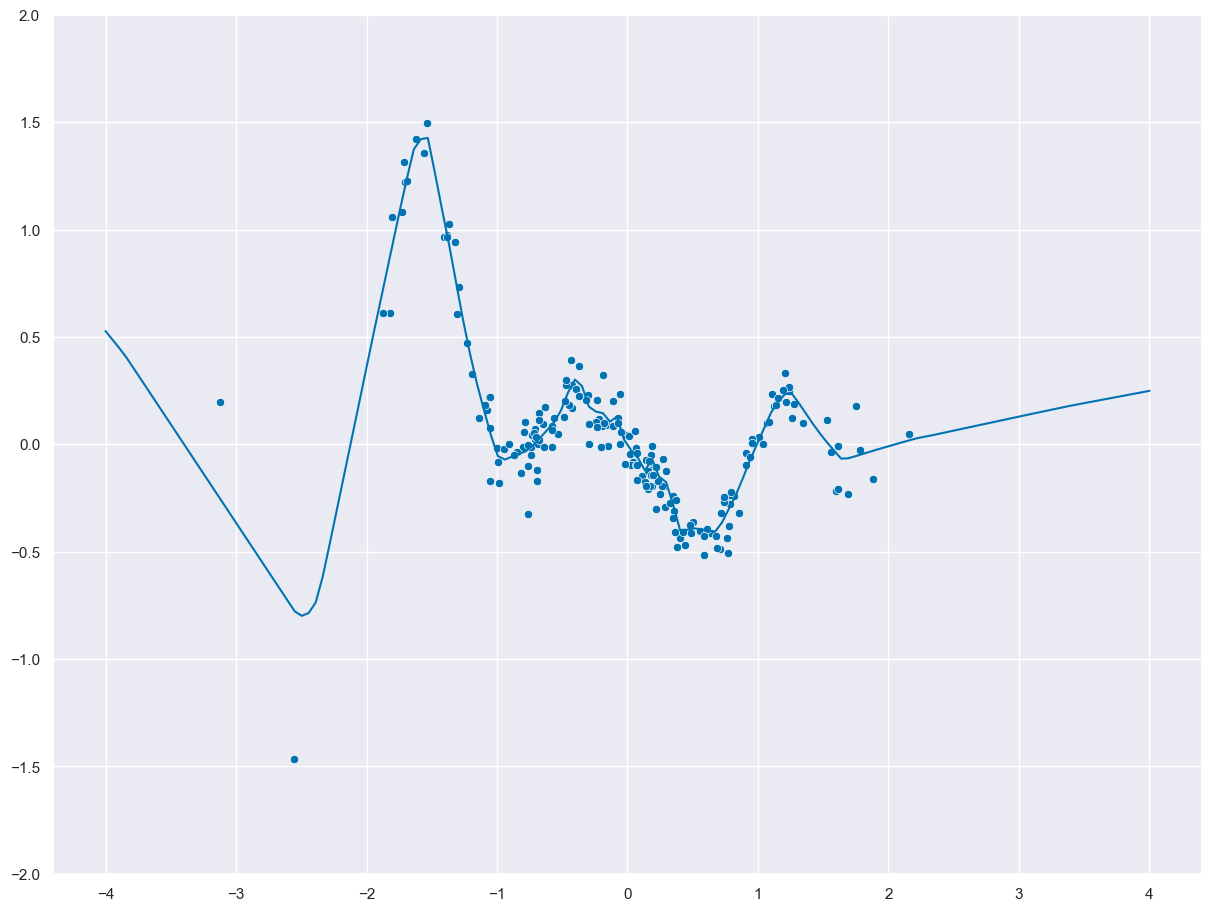

In [31]:
# Visualize the point-estimate results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_preds, ax=ax)
ax.set_ylim(-2., 2.);

### 1.1.2 In-Between Dataset

In [32]:
# Train on in-between data
trained_inbtwn_state = fit(config, apply_fn, flat_params, n_train, X_inbtwn_train, y_inbtwn_train)

Epoch 20 - loss: 0.18940040469169617
Epoch 40 - loss: 0.14974282681941986
Epoch 60 - loss: 0.1257147490978241
Epoch 80 - loss: 0.09484945237636566
Epoch 100 - loss: 0.10978458821773529
Epoch 120 - loss: 0.07205527275800705
Epoch 140 - loss: 0.04459984228014946
Epoch 160 - loss: 0.02637895755469799
Epoch 180 - loss: 0.01468086987733841
Epoch 200 - loss: 0.010913575068116188
Epoch 220 - loss: 0.012415765784680843
Epoch 240 - loss: 0.008301861584186554
Epoch 260 - loss: 0.011328320018947124
Epoch 280 - loss: 0.010084567591547966
Epoch 300 - loss: 0.008115986362099648
Epoch 320 - loss: 0.008048877120018005
Epoch 340 - loss: 0.009552881121635437
Epoch 360 - loss: 0.0070784930139780045
Epoch 380 - loss: 0.007313875015825033
Epoch 400 - loss: 0.00723761972039938
Epoch 420 - loss: 0.014364484697580338
Epoch 440 - loss: 0.009568661451339722
Epoch 460 - loss: 0.006206179969012737
Epoch 480 - loss: 0.006475082598626614
Epoch 500 - loss: 0.006637911312282085


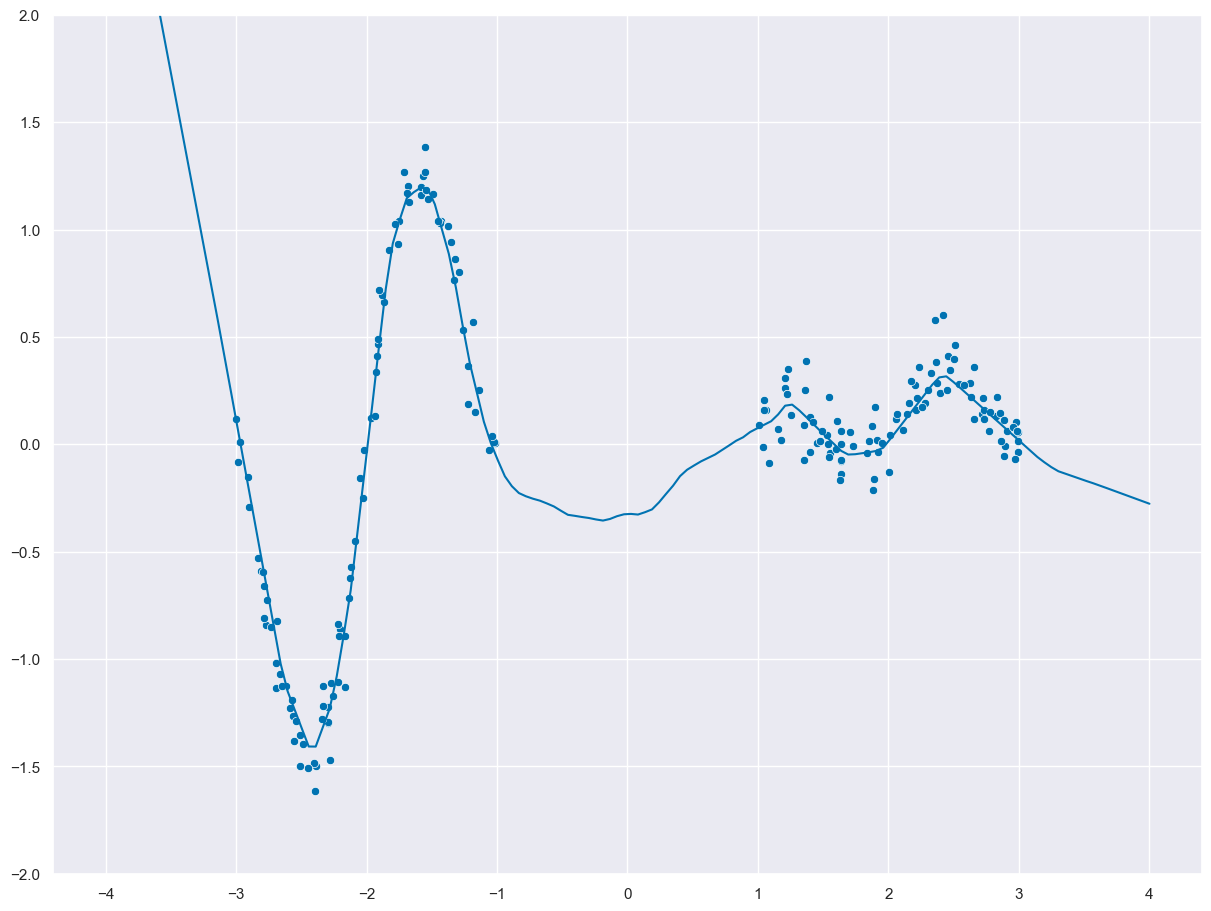

In [33]:
# Evaluate trained model on grid
y_inbtwn_preds = vmap(apply_fn, (None, 0))(trained_inbtwn_state.params, X_grid).squeeze()

# Visualize the point-estimate results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_inbtwn_preds, ax=ax)
ax.set_ylim(-2., 2.);

## 1.2 Uncertainty Estimates

### 1.2.1 Full Dataset

In [37]:
# Compute penultimate layer results
phi_train = vmap(get_features, (None, 0))(trained_state.params, X_train)
phi_test = vmap(get_features, (None, 0))(trained_state.params, X_grid)
print(phi_train.shape, phi_test.shape)

(200, 100) (150, 100)


To compute the posterior covariance, we treat the final layer as a Bayesian linear regression model and analytically solve for $\phi(x)^{\top}\left(\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}\right)^{-1}\phi(x)$.

In [38]:
post_cov = phi_test @ jnp.linalg.pinv(phi_train.T @ phi_train/obs_var + jnp.eye(n_features)) @ phi_test.T
post_cov += 1e-5 * jnp.eye(len(post_cov)) # to ensure positive definiteness
post_std = jnp.sqrt(jnp.diag(post_cov))

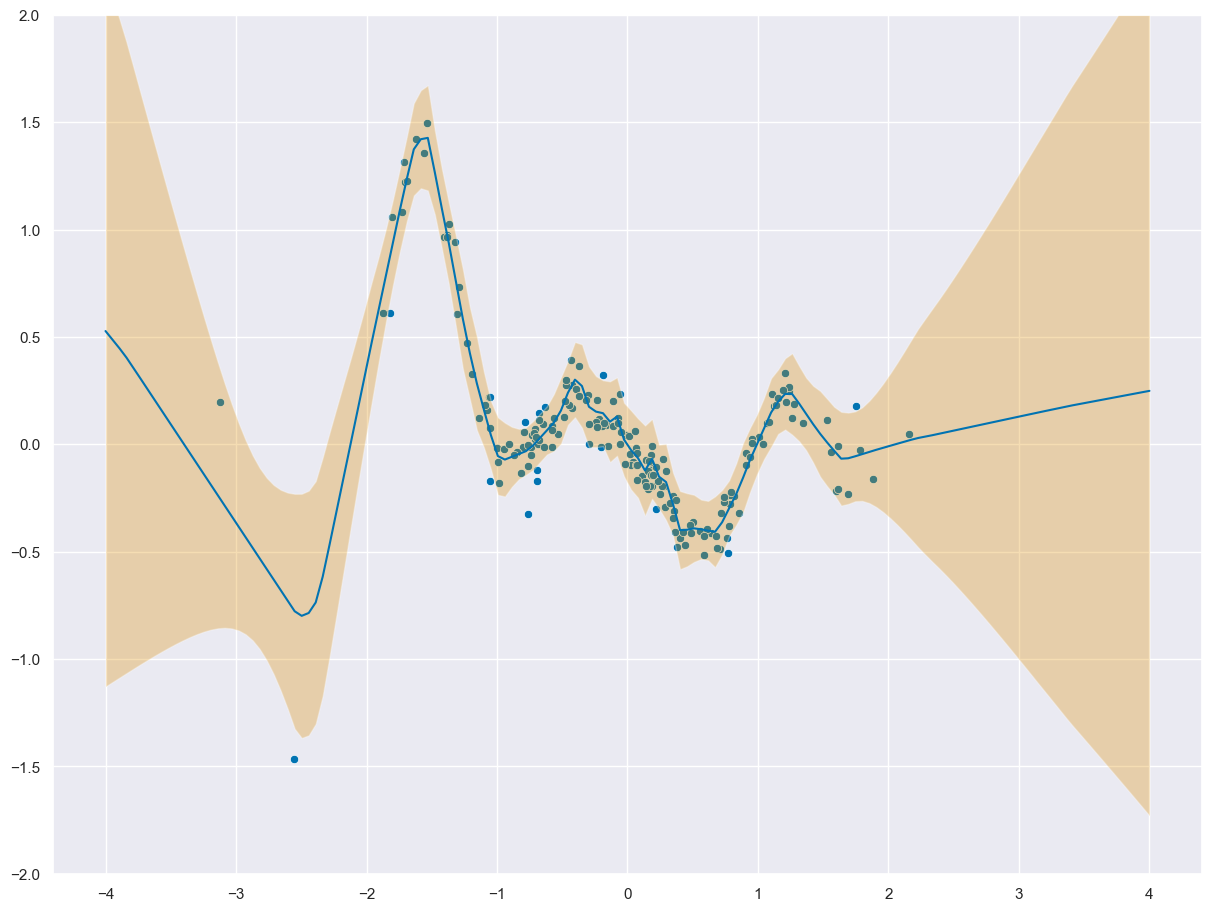

In [39]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_preds, ax=ax)
ax.fill_between(
    X_grid, y_preds - 1.96*post_std, y_preds + 1.96*post_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 1.2.2 In-Between Dataset

In [40]:
# Compute penultimate layer results
phi_inbtwn_train = vmap(get_features, (None, 0))(trained_inbtwn_state.params, X_inbtwn_train)
phi_inbtwn_test = vmap(get_features, (None, 0))(trained_inbtwn_state.params, X_grid)
print(phi_inbtwn_train.shape, phi_inbtwn_test.shape)

(200, 100) (150, 100)


In [41]:
post_inbtwn_cov = phi_inbtwn_test @ jnp.linalg.pinv(phi_inbtwn_train.T @ phi_inbtwn_train/obs_var + jnp.eye(n_features)) @ phi_inbtwn_test.T
post_inbtwn_cov += 1e-5 * jnp.eye(len(post_inbtwn_cov)) # to ensure positive definiteness
post_inbtwn_std = jnp.sqrt(jnp.diag(post_inbtwn_cov))

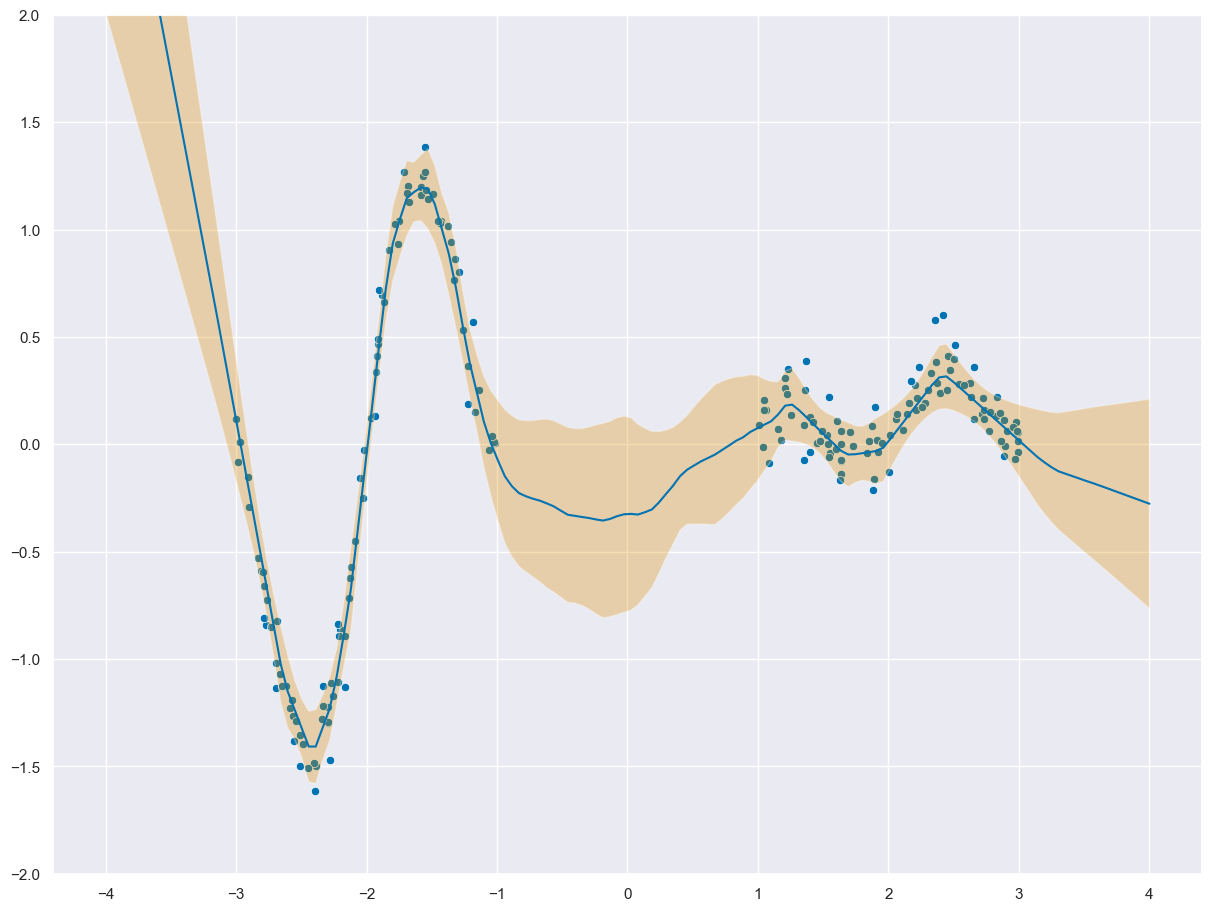

In [43]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_inbtwn_preds, ax=ax)
ax.fill_between(
    X_grid, y_inbtwn_preds - 1.96*post_inbtwn_std, y_inbtwn_preds + 1.96*post_inbtwn_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 1.3 Posterior Predictive Sampling

### 1.3.1 Full Dataset

In [44]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=y_preds, covariance_matrix=post_cov).sample((100,), seed=jr.PRNGKey(0))

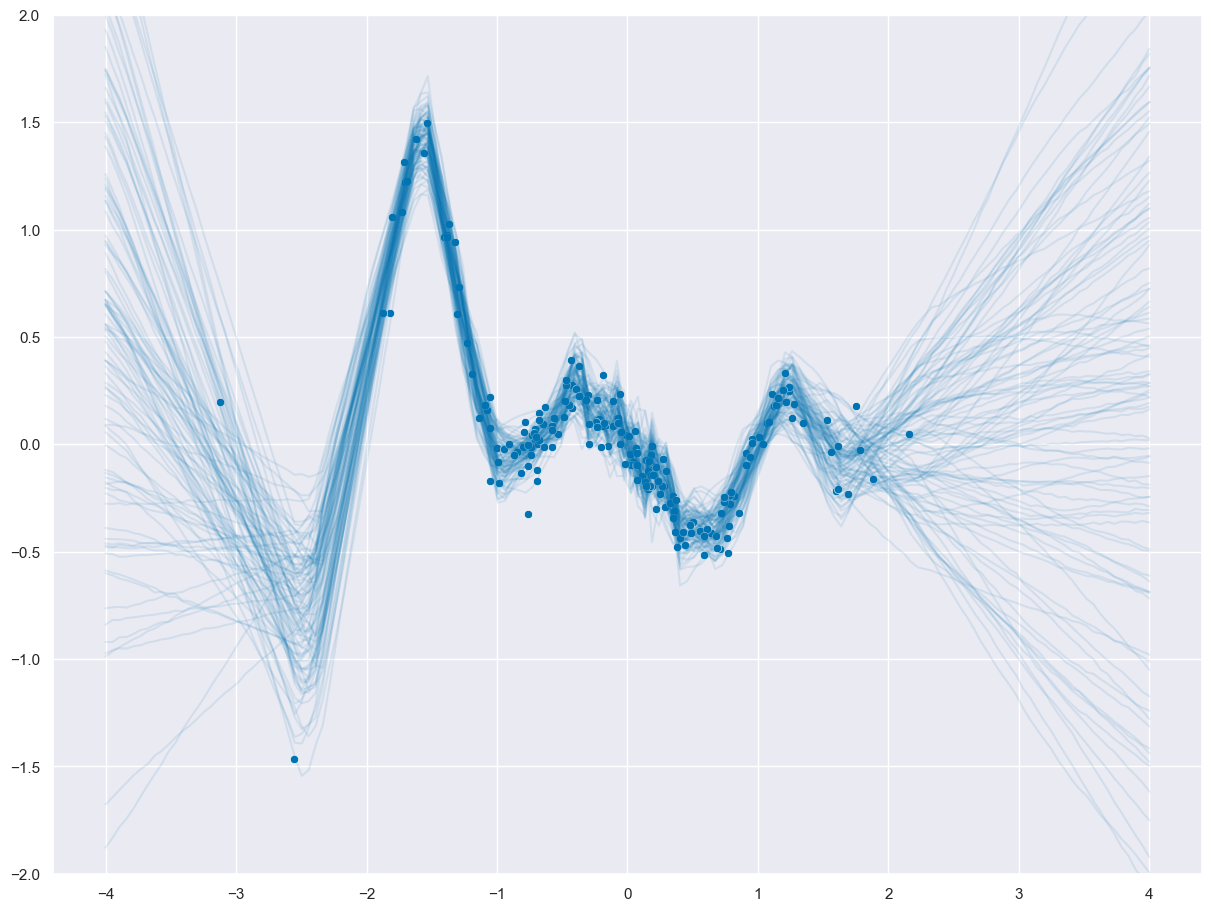

In [45]:
# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

### 1.3.2 In-Between Dataset

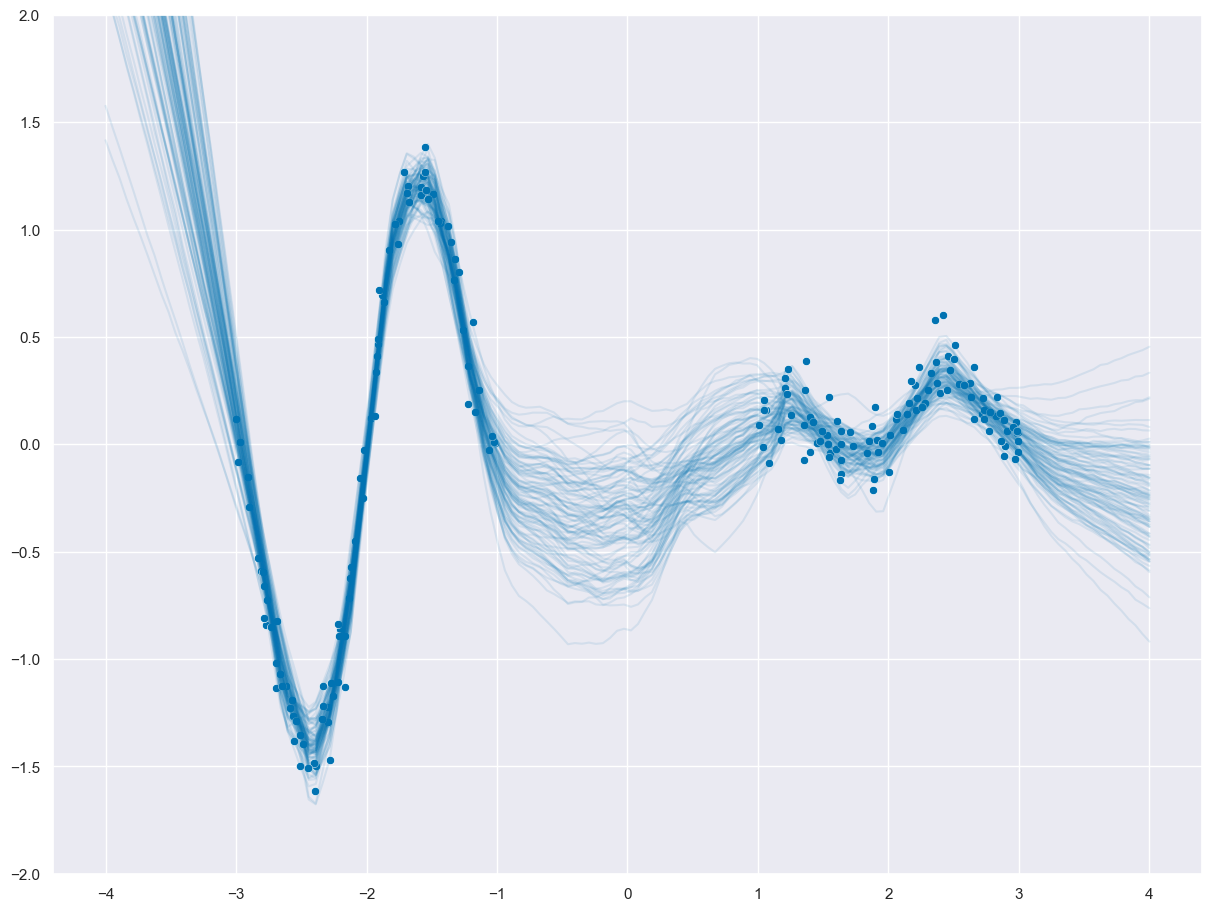

In [46]:
# Take 100 samples from the posterior predictive distribution
f_inbtwn_samples = MVN(loc=y_inbtwn_preds, covariance_matrix=post_inbtwn_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
for func in f_inbtwn_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);